Notebooks 01a and 01b are used together to get residence-time distribution (RTD) for the entire aquifer from an existing MODFLOW model. It is possible to read in any group or label from a 3D array and make RTDs for those groups. The approach is to 
* read an existing model
* create flux-weighted particle starting locations in every cell
* run MODPATH and read endpoints
* fit parametric distributions to endpoints

Notebook 01a (this notebook) creates flux-weighted particles and runs MODPATH.  Notebook 01b fits parametric distributions.

In [10]:
__author__ = 'Jeff Starn'
%matplotlib notebook

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from IPython.display import Image
from IPython.display import Math
from ipywidgets import interact, Dropdown
from IPython.display import display

import os
import sys
import shutil
import pickle
import numpy as np
import datetime as dt
import flopy as fp
import imeth
import pandas as pd
import matplotlib.transforms as mtransforms
import geopandas as gpd
import gdal

# Preliminary stuff

## User-defined variables

**IMPORTANT** 

The directory name where the model is has to be the same as the base name of the MODFLOW name file.

**Time specification**

MODFLOW and MODPATH use elapsed time and are not aware of calendar time. To place MODFLOW/MODPATH elapsed time on the calendar, two calendar dates are specified at the top of the notebook: the beginning of the first stress period (`mf_start_date`) and when particles are to be released (`mp_release_date`). The latter date could be used in many ways, for example to represent a sampling date, or it could be looped over to create a time-lapse set of ages. 

There are several time-related definitons used in MODPATH.
* `simulation time` is the elapsed time in model time units from the beginning of the first stress period
* `reference time` is an arbitrary value of `simulation time` that is between the beginning and ending of `simulation time`
* `tracking time` is the elapsed time relative to `reference time`. It is always positive regardless of whether particles are tracked forward or backward
* `release time` is when a particle is released and is specified in `tracking time`

Particles will be released on the date `mp_release_date_str` relative to the starting time `mf_start_date_str`. The latter date is arbitrary; it is used to set the calendar date for the beginning of the first stress period. The length of the first stress period, even though it is usualy steady state, should correspond to the length of time between `mf_start_date_str` and the start of the first transient stress period. The notebook will calculate `release time` in units of `tracking time` for the `mp_release_date`.

`layer_for_flow_calc` is an arbitrary layer number on which to divide the model domain for calculating RTDs. For example, in glacial aquifers it could represent the layer number of the bottom of unconsolidated deposits. In that case, anything below this layer could be considered bedrock.

`num_depth_groups` is an arbitrary number of equally groups starting from the water table to the bottom of the lowest model layer.



## Loop through home directory to get list of name files

In [59]:
homes = ['../Models']
fig_dir = '../Figures'

mfpth = '../executables/MODFLOW-NWT_1.0.9/bin/MODFLOW-NWT_64.exe'
mp_exe_name = '../executables/modpath.6_0/bin/mp6.exe' 
source_grid = 'top.tif'

mf_start_date_str = '01/01/1900' 
mp_release_date_str = '01/01/2020' 

# Read the zone array:
# use 'None' if there is no zone array
# the zone array should be either a comma-delimited file (.csv) with dimensions
# (nrow * ncol, nlay) or a compressed numpy array (.npz) with dimensions (nlay, nrow, ncol).
# The file with this name has to be in the model workspace directory defined later
zone_array_src = 'nacp_newzones_list_adj_2017.csv'

layer_for_flow_calc = 3

por = 0.20

dir_list = []
mod_list = []
i = 0

for home in homes:
    if os.path.exists(home):
        for dirpath, dirnames, filenames in os.walk(home):
            for f in filenames:
                if os.path.splitext(f)[-1] == '.nam':
                    mod = os.path.splitext(f)[0]
                    mod_list.append(mod)
                    dir_list.append(dirpath)
                    i += 1
print('    {} models read'.format(i))

model_area = Dropdown(
    options=mod_list,
    description='Model:',
    background_color='cyan',
    border_color='black',
    border_width=2)
display(model_area)

with open('dir_list.txt', 'w') as f:
    for i in dir_list:
        f.write('{}\n'.format(i))

    2 models read


Dropdown(description='Model:', options=('LIMODEL', 'NA_TRNWT'), value='LIMODEL')

##  Create names and path for model workspace. 

The procedures in this notebook can be run from the notebook or from a batch file by downloading the notebook as a Python script and uncommenting the following code and commenting out the following block. The remainder of the script has to be indented to be included in the loop.  This may require familiarity with Python. 

In [60]:
# for pth in dir_list:
#     model = os.path.normpath(pth).split(os.sep)[2]
#     model_ws = [item for item in dir_list if model in item][0]
#     nam_file = '{}.nam'.format(model)
#     print("working model is {}".format(model_ws))

In [61]:
model = model_area.value
model_ws = [item for item in dir_list if model in item][0]
nam_file = '{}.nam'.format(model)
print("working model is {}".format(model_ws))

working model is ../Models\NACP\NA_TRNWT


# Load an existing model

In [62]:
print ('Reading model information')

fpmg = fp.modflow.Modflow.load(nam_file, model_ws=model_ws, exe_name=mfpth, version='mfnwt', 
                               load_only=['DIS', 'BAS6', 'UPW', 'OC'], check=False)

dis = fpmg.get_package('DIS')
bas = fpmg.get_package('BAS6')
upw = fpmg.get_package('UPW')
oc = fpmg.get_package('OC')

delr = dis.delr
delc = dis.delc
nlay = dis.nlay
nrow = dis.nrow
ncol = dis.ncol
bot = dis.getbotm()
top = dis.gettop()

hnoflo = bas.hnoflo
ibound = np.asarray(bas.ibound.get_value())
hdry = upw.hdry

print ('   ... done') 

Reading model information
   ... done


FloPy loads MODFLOW packages but not their name-file unit numbers, so these have to be read separately.

In [63]:
src = os.path.join(model_ws, fpmg.namefile)
name_file_df = pd.read_table(src, header=None, comment='#', delim_whitespace=True, 
              names=['package', 'unit', 'filename', 'type'])

name_file_df['package'] = name_file_df.package.str.lower()
name_file_df.set_index('unit', inplace=True)

head_file_name = name_file_df.loc[oc.iuhead, 'filename']
bud_file_name = name_file_df.loc[oc.get_budgetunit(), 'filename']

## Calculation of time in MODFLOW/MODPATH

In [64]:
# Create dictionary of multipliers for converting model time units to days
time_dict = dict()
time_dict[0] = 1.0 # undefined assumes days
time_dict[1] = 24 * 60 * 60
time_dict[2] = 24 * 60
time_dict[3] = 24
time_dict[4] = 1.0
time_dict[5] = 1.0

# convert string representation of dates into Python datetime objects
mf_start_date = dt.datetime.strptime(mf_start_date_str , '%m/%d/%Y')
mp_release_date = dt.datetime.strptime(mp_release_date_str , '%m/%d/%Y')

# convert simulation time to days from the units specified in the MODFLOW DIS file
sim_time = np.append(0, dis.get_totim())
sim_time /= time_dict[dis.itmuni]

# make a list of simulation time formatted as calendar dates
date_list = [mf_start_date + dt.timedelta(days = item) for item in sim_time]

# reference time and date are set to the end of the last stress period
ref_time = sim_time[-1]
ref_date = date_list[-1]

# release time is calculated in tracking time (for particle release) and 
# in simulation time (for identifying head and budget components)
release_time_trk = np.abs((ref_date - mp_release_date).days)
release_time_sim = (mp_release_date - mf_start_date).days

## Read budget file records

In [65]:
src = os.path.join(model_ws, bud_file_name)
bud_obj = fp.utils.CellBudgetFile(src)
all_bud_df = pd.DataFrame(bud_obj.recordarray)

# convert to zero base
all_bud_df['kper'] = all_bud_df['kper'] - 1
all_bud_df['kstp'] = all_bud_df['kstp'] - 1

# add calendar date (not used at this time)
all_bud_df['date'] = mf_start_date + pd.to_timedelta(all_bud_df.totim, unit='days')

## Identify time step and stress period for particle release

* read all stress periods and time steps that were preserved in the budget file
* find the largest (latest) stress period and time step that include the mp_release_date
* make a subset of all the budget records from the specified period and step

In [66]:
# group by period and step
kdf = all_bud_df.groupby(['kper', 'kstp']).median()

# find the latest group index that includes the release date
idx = kdf.loc[(kdf.totim >= release_time_sim).idxmax(), :].name

# switch period and step 
kstpkper = tuple(item for item in idx[-1::-1])

# extract the budget records for the specified period and step
bud_df = all_bud_df.query('kstp=={} and kper=={}'.format(*kstpkper)).copy()

bud_df.loc[:, 'per_num'] = bud_df.totim.factorize()[0]
num_rec = bud_df.shape[0]

## Read zone array to use as particle label

In [67]:
zone_array_src = os.path.join(model_ws, zone_array_src)

if 'None' not in zone_array_src:
    ext = os.path.splitext(zone_array_src)[1].lower()
    if ext == '.csv':
        zones = pd.read_csv(zone_array_src)
        zones = zones.unstack().values.reshape(nlay, nrow, ncol)
    elif (ext == '.zon') | (ext == '.zone'):
        # option to read zones from a MODFLOW zone package file not implemented
        pass 
    elif ext == '.npz':
        d = np.load(zone_array_src)
        if len(d.items()) != 1:
            print('There should only be one item type in the npz file and ')
            print('it should be an array dimensioned as (nlay, nrow, ncol)')
        else:
            zones = d.items()[0][1]
else:
    zones = np.ones((nlay * nrow * ncol))

## Extract specified flows from MODFLOW budget

Get recharge at top model surface (recharge package only at this time) and flow across the bottom of all cells in the zone tuple. 

In [68]:
if b'        RECHARGE' in bud_df.text.values:
    # probably should make this so that recharge is summed from the highest active cell
    rch = bud_obj.get_data(text='RECHARGE', kstpkper=kstpkper, full3D=True)
    recharge_vol = rch[0].sum()  
else:
    print('no recharge')
# This assumes all recharge is from RCH package. Should add a check for UZF package & concat them

In [69]:
if layer_for_flow_calc <= nlay:  
    flf = bud_obj.get_data(text='FLOW LOWER FACE', kstpkper=kstpkper, full3D=True)
    flow2rock = flf[0][layer_for_flow_calc - 1, :, :]
    bedrock_recharge_vol = flow2rock[flow2rock > 0].sum()
    bed_frac = bedrock_recharge_vol / recharge_vol
else:
    print('invalid layer_for_flow_calc')

## Read head file
The head file is used limit particle placement to the saturated part of each cell and to identify dry cells.

In [80]:
src = os.path.join(model_ws, head_file_name)
hd_obj = fp.utils.HeadFile(src)
head_df = pd.DataFrame(hd_obj.recordarray)

heads = hd_obj.get_data(kstpkper=kstpkper)

## Calculate saturated thickness and volume for each cell.
* create 3D model cell boundary grid
* saturated top in cell is minimum of head or cell top
* saturated thickness is the distance between the saturated top and cell bottom
* if the cell is dry or inactive, the saturated thickness is zero


In [71]:
# create a 3D array of layer boundaries
grid = np.zeros((nlay+1, nrow, ncol))
grid[0, :, :] = top
grid[1:, :, :] = bot

# tmp is the minimum of the head and cell top 
tmp = np.minimum(heads, grid[:-1, :, :])

# the saturated thickness is first estimated to be the difference between tmp and the cell bottom
sat_thk_cell = (tmp - grid[1:, :, :]) 

# sat_thk_cell < 0 means the head is below the bottom of the cell; these are set to zero
sat_thk_cell[sat_thk_cell < 0] = 0

## Calculate the mean exponential age 

Based on simulated recharge volumteric rate and simulated aquifer volume. Calculations are for the entire model (total) and for layers above and below the layer specified at the top of the notebook as `layer_for_flow_calc`.

In [72]:
# create grid cell dimension arrays
delc_ar, dum, delr_ar = np.meshgrid(delc, np.arange(nlay), delr)

# saturated volume of each cell
sat_vol_cell = sat_thk_cell * delc_ar * delr_ar

# sum totals
total_sat_vol = sat_vol_cell.sum()
total_sat_vol_glac = sat_vol_cell[0:layer_for_flow_calc, :, :].sum()
total_sat_vol_bedr = sat_vol_cell[layer_for_flow_calc:, :, :].sum()

tau_glacial = total_sat_vol_glac * por / recharge_vol / 365.25
tau_bedrock = total_sat_vol_bedr * por / bedrock_recharge_vol  / 365.25
tau_total = total_sat_vol * por / recharge_vol /  365.25

In [73]:
print('tau total = {:8.0f} years'.format(tau_total))
print('tau above = {:8.0f} years'.format(tau_glacial))
print('tau below = {:8.0f} years'.format(tau_bedrock))

tau total =     2226 years
tau above =      160 years
tau below =     6450 years


In [74]:
dst = os.path.join(model_ws, 'tau.txt')
with open(dst, 'w') as f:
    line = 'Mean exponential age in glacial is {0:0.6f} years\n'.format(tau_glacial)
    f.write(line)
    line = 'Mean exponential age in bedrock is {0:0.6f} years\n'.format(tau_bedrock)
    f.write(line)
    line = 'Mean exponential age in total is {0:0.6f} years\n'.format(tau_total)
    f.write(line)
    line = 'Inflow to bedrock is {0:0.0f} cubic meters per day\n'.format(bedrock_recharge_vol)
    f.write(line)
    line = 'Inflow to bedrock is {0:0.3f} of total recharge\n'.format(bed_frac)
    f.write(line)

# Make MODPATH input files and run MODPATH

## Calculate inflow into each cell
The number of particles in each cell is in proportion to the flux into the cell. Particle locations within a cell are generated randomly. The proportion constant is calculated from the desired total number of particles. Number of particles per cell is proportional to the flow into the cell such that the total number of particles = `t_num_parts`, in this case 2 million. 

MODFLOW includes a variable called `imeth` in the budget file. `imeth` is used to specify the format in which the budget data are stored. Functions for reading `imeth` for each of the data formats are defined in the module imeth.py.

In [75]:
flow_times = bud_df.totim.unique()
nt = bud_df.per_num.nunique()

rxc = dis.nrow * dis.ncol
nn = dis.nlay * rxc

im = imeth.imeth(nlay, nrow, ncol)

qx1 = np.zeros((nt, nn))
qx2 = np.zeros_like(qx1)
qy1 = np.zeros_like(qx1)
qy2 = np.zeros_like(qx1)
qz1 = np.zeros_like(qx1)
qz2 = np.zeros_like(qx1)
storage = np.zeros_like(qx1)

bound_flow = np.zeros((nn, 7))
int_flow_right = np.zeros((nn))
int_flow_left = np.zeros((nn))
int_flow_front = np.zeros((nn))
int_flow_back = np.zeros((nn))
int_flow_lower = np.zeros((nn))
int_flow_top = np.zeros((nn))

for i, rec in bud_df.iterrows():

    BUFF = bud_obj.get_record(i)
    
    internal_flow_list = [b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'STORAGE']

    if rec.text in internal_flow_list:
        if b'   CONSTANT HEAD' in rec.text:
            bound_flow += im.imeth2(BUFF)
        elif b'FLOW RIGHT FACE ' in rec.text:
            int_flow_right = im.imeth1(BUFF)
            int_flow_left = np.roll(int_flow_right, 1)
        elif b'FLOW FRONT FACE ' in rec.text:
            int_flow_front = im.imeth1(BUFF)
            int_flow_back = np.roll(int_flow_front, ncol)
        elif b'FLOW LOWER FACE ' in rec.text:
            int_flow_lower = im.imeth1(BUFF)
            int_flow_top = np.roll(int_flow_lower, rxc)
        elif b'STORAGE' in rec.text:
            bound_flow[: , 0] += im.imeth1(BUFF)
        else:
            print('Unrecognized budget type')

    if rec.text not in internal_flow_list:
        if rec.imeth == 1:
            bound_flow[:, 0] += im.imeth1(BUFF)
        elif rec.imeth == 2:
            bound_flow[:, 0] += im.imeth2(BUFF)
        elif rec.imeth == 3:
            bound_flow += im.imeth3(BUFF)
        elif rec.imeth == 4:
            bound_flow += im.imeth4(BUFF)
        elif rec.imeth == 5:
            bound_flow += im.imeth5(BUFF)
        else:
            print('Unrecognized budget type')

    storage[rec.per_num , :] += bound_flow[:, 0]

    qx1[rec.per_num , :] = int_flow_left + bound_flow[:, 1]
    qx2[rec.per_num , :] = int_flow_right - bound_flow[:, 2]

    qy1[rec.per_num , :] = -int_flow_front + bound_flow[:, 3]
    qy2[rec.per_num , :] = -int_flow_back - bound_flow[:, 4]

    qz1[rec.per_num , :] = -int_flow_lower + bound_flow[:, 5]
    qz2[rec.per_num , :] = -int_flow_top - bound_flow[:, 6]

qin1 = np.where(qx1 > 0, qx1, 0)
qin2 = np.where(qx2 < 0, -qx2, 0)
qin3 = np.where(qy1 > 0, qy1, 0)
qin4 = np.where(qy2 < 0, -qy2, 0)
qin5 = np.where(qz1 > 0, qz1, 0)
qin6 = np.where(qz2 < 0, -qz2, 0)

flow_sum = np.sum((qin1, qin2, qin3, qin4, qin5, qin6), axis=0)

# set the flow to zero for cells that went dry during the simulation and also for isolated cells
flow_sum[0, heads.ravel() == hdry] = 0
# flow_sum[heads.ravel() > 1.E+29] = 0

print ('   ... done'  )

   ... done


## Repeat cell coordinates for the number of particles

In [76]:
src = os.path.join(os.path.dirname(model_ws), source_grid)
raster = gdal.Open(src)
ibound = raster.ReadAsArray()

gt = raster.GetGeoTransform()
proj = raster.GetProjection()
shapeproj = raster.GetProjection()
width = raster.RasterXSize
height = raster.RasterYSize

# this arrangement of letters is from the GDAL docs
c, a, b, f, e, d = gt

# matplotlib transform puts the origin in the last column, 
# so the columns are re-arranged here
# matplotlib also plots the origin at the cell corner rather than the center,
# so the grid origin is shifted by half a pixel
mt = np.array([[a, b, c + a / 2], [e, d, f + d / 2], [0, 0, 1]])
# create the coordinate transform from model grid to geographic
mta = mtransforms.Affine2D(mt)
# # combine the grid transform with the axis transform
# trans_data = mta + ax.transData

raster = None

# reverse transform cell-center coordinates to projected coordinates
r, c = np.indices((nrow, ncol))
dum = np.column_stack((c.ravel() + 0.5, r.ravel() + 0.5)) 
dat = mta.transform(dum)

# use cell coordinates to get grid extent
xmin = dat[:,0].min()
xmax = dat[:,0].max()
ymin = dat[:,1].min()
ymax = dat[:,1].max()

<IPython.core.display.Javascript object>


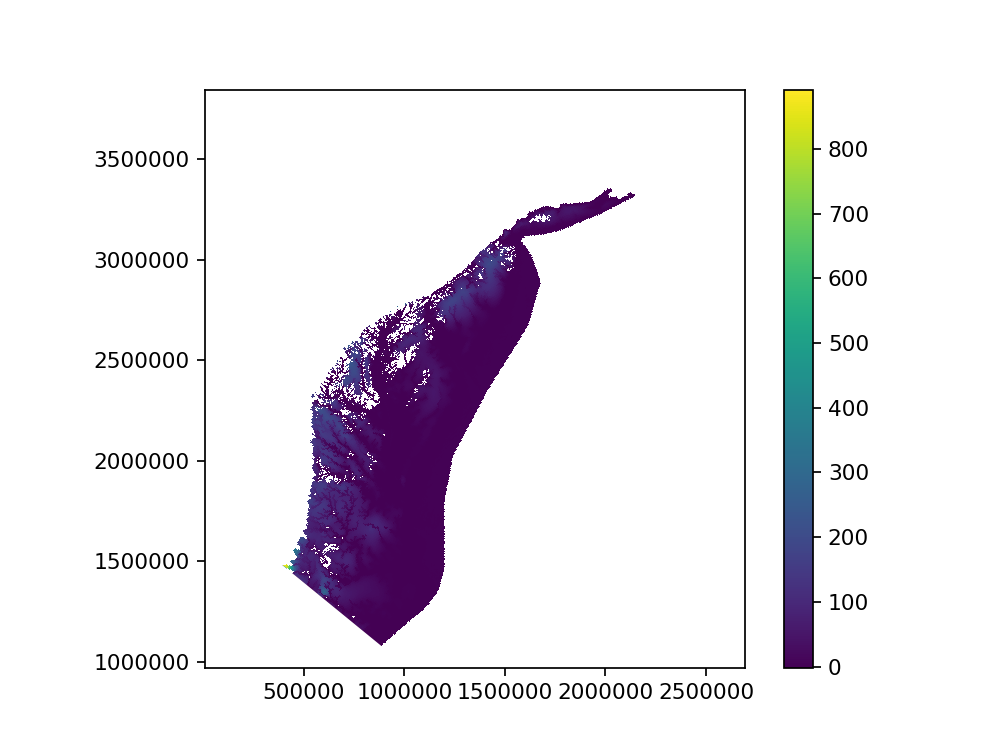

(972416.0636902342, 3844293.6356353)

In [82]:
fig, ax = plt.subplots(1, 1)
# combine the grid transform with the axis transform
trans_data = mta + ax.transData

heads[heads == hdry] = np.nan
heads[heads == hnoflo] = np.nan

im = ax.imshow(heads[0, : ,:], transform = trans_data)
fig.colorbar(im)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

In [83]:
t_num_parts =  2.0E+06
# flow_per_period = flow_sum[0, :]
flow_per_period = sat_vol_cell.ravel()

f = t_num_parts / flow_per_period.sum()

parts_per_cell = np.rint( flow_per_period * f ).astype( np.int32 )

l, r, c = np.indices(( nlay, nrow, ncol ))

lrep = np.repeat( l, parts_per_cell.ravel() )
rrep = np.repeat( r, parts_per_cell.ravel() )
crep = np.repeat( c, parts_per_cell.ravel() )
label = np.repeat( zones, parts_per_cell.ravel() )
num_parts = lrep.shape[0]

print(num_parts)

1957731


In [ ]:
print('Min  number of particles per active cell = {:10.0f}'.format(parts_per_cell[ibound.ravel() != 0].min()))
print('Mean number of particles per active cell = {:10.0f}'.format(parts_per_cell[ibound.ravel() != 0].mean()))
print('Max  number of particles per active cell = {:10.0f}'.format(parts_per_cell[ibound.ravel() != 0].max()))

## Generate random particle placement in the saturated part of each cell

MODPATH wants particle locations as the layer, row, column (which we now have) plus the relative cell coordinates within each cell over (0, 1). In this application relative cell coordinates are generated randomly. In convertible cells (i.e., in a water table layer) MODPATH treats the water table as the top of the cell. In other words, the water table is at 1.0 in relative cell coordinates. In non-convertible cells, the top of the cell is at 1.0. Thus, in partially saturated cells, the random particle location is scaled to the saturated thickness. 

In [ ]:
# specify seed for random number generator--could be any integer value
prng = np.random.RandomState(2909591)

In [ ]:
# generate random relative coordinates within a cell in 3D
cell_coords = prng.rand( num_parts, 3 )

# calculate the fraction of saturation; unsaturated = 0, partially saturated 0 to 1, fully saturated = 1
vfrac = sat_thk_cell / -np.diff(grid, axis=0)

## Assign depth related group number

Particle groups are assigned based on the relative position. Other approaches could be substitued.  They must be integers. Zone numbers can be read into the label variable. 

In [ ]:
# percent_thk_lay = sat_thk_cell[:layer_for_flow_calc, :, :] / sat_thk_cell[:layer_for_flow_calc, :, :].sum(axis=0)
# percent_thk_lay_cum = 1 - np.cumsum(percent_thk_lay, axis=0)

# z_cell = cell_coords[:, 2]
# rel_z_pos = percent_thk_lay_cum[lrep, rrep, crep] + z_cell * percent_thk_lay[lrep, rrep, crep]
# group = np.digitize(1 - rel_z_pos, np.linspace(0, 1, num_depth_groups + 1))
group = 1

## Create particle array
Particles locations are assembled into an array in MODPATH format. Then sort them by group. MODPATH seems to like that.

In [ ]:
particles = np.zeros( ( num_parts, 11 ) )
particles[:, 0] = np.arange( 1, num_parts + 1 )
particles[:, 1] = group
particles[:, 2] = 1
particles[:, 3] = lrep + 1
particles[:, 4] = rrep + 1
particles[:, 5] = crep + 1
particles[:, 6:9] = cell_coords
particles[:, 9] = release_time_trk
particles[:, 10] = label

## Write particle starting locations
The external particle starting locations file is written, including header information.

In [ ]:
print('   Write starting locations for {} particles'.format(particles.shape[0]))

num_depth_groups = 1
PartStartForm = '%6d %6d %3d %3d %3d %3d %12.9f %12.9f %12.9f %12.9e %15.3f'
line = '{:5d}\n{:5d}\n'.format(1, num_depth_groups + 1)
for item in range(1, num_depth_groups + 2):
    line = line + 'group_{}\n'.format(item)
    npart = ((particles[:, 1]) == item).sum()
    if item == (num_depth_groups + 1):
        line = line + '{:6d}'.format(npart)
    else:
        line = line + '{:6d}\n'.format(npart)
dst_pth = os.path.join(model_ws, '{}_flux.loc'.format(fpmg.name))
np.savetxt(dst_pth, particles, delimiter=' ', fmt=PartStartForm, header=line, comments='')

print ('   ... done')

# Run MODPATH and read endpoint information

## Get random cells to check budget computations
Select 10 random active cells to check cell budget

In [ ]:
A = (particles[:, 3:6] - 1)
A = A[prng.choice(A.shape[0], 10, replace=False), :]
budchk = np.ones((10, 4))
budchk[:, 1:] = A
budchk = budchk.astype(np.int32())
budchk = budchk.tolist()

## Run MODPATH

In [ ]:
print('   Write and run MODPATH')

# prepare Modpath files   
SimulationType = 1              # 1 endpoint; 2 pathline; 3 timeseries
TrackingDirection = 2           # 1 forward; 2 backward
WeakSinkOption = 1              # 1 pass; 2 stop
WeakSourceOption = 1            # 1 pass; 2 stop
ReferemceTimeOption = 1         # 1 time value; 2 stress period, time step, relative offset
StopOption = 2                  # 1 stop with simulation 2; extend if steady state 3; specify time
ParticleGenerationOption = 2    # 1 automatic; 2 external file
TimePointOption = 1             # 1 none; 2 number at fixed intervals; 3 array
BudgetOutputOption = 3          # 1 none; 2 summary; 3 list of cells; 4 trace mode
ZoneArrayOption = 1             # 1 none; 2 read zone array(s) 
RetardationOption = 1           # 1 none; 2 read array(s) 
AdvectiveObservationsOption = 1 # 1 none; 2 saved for all time pts 3; saved for final time pt

options = [SimulationType, TrackingDirection, WeakSinkOption, WeakSourceOption, ReferemceTimeOption, 
           StopOption, ParticleGenerationOption, TimePointOption, BudgetOutputOption, ZoneArrayOption, 
           RetardationOption, AdvectiveObservationsOption]

mpname = '{}_flux'.format(fpmg.name)
mp = fp.modpath.Modpath(modelname=mpname, modflowmodel=fpmg, dis_file=dis.file_name[0], exe_name=mp_exe_name,
                        model_ws=model_ws, simfile_ext='mpsim', dis_unit=dis.unit_number[0])

mpnf = '{}.mpnam'.format(fpmg.name)
mplf = '{}.mplst'.format(fpmg.name)

mpsim = fp.modpath.ModpathSim(mp, mp_name_file=mpnf, 
                              mp_list_file=mplf, 
                              option_flags=options,
                              ref_time=ref_time,
                              cell_bd_ct=10, 
                              bud_loc=budchk,
                              extension='mpsim')

mpbas = fp.modpath.ModpathBas(mp, hnoflo=hnoflo, hdry=hdry, 
                              def_face_ct=1, bud_label=['RECHARGE'], def_iface=[6], 
                              laytyp=upw.laytyp.get_value(), ibound=ibound, 
                              prsity=por, prsityCB=0.20)    

mp.write_input()
success, msg = mp.run_model(silent=False, report=True)

# delete starting locations to save space--this information is now in the endpoint file
if success:
    dst_pth = os.path.join(model_ws, '{}_flux.loc'.format(fpmg.name))
    os.remove(dst_pth)

print ('   ... done')

## Check budget
Compare the calculated composite budget in the notebook to the cell budget output from MODPATH.

In [ ]:
with open(os.path.join(model_ws, '{}.mplst'.format(mpname)), 'r') as f:
    lines = f.readlines()

for n, item in enumerate(lines):
    if (('Processing Time Step' in item) & (str(kstpkper[1] + 1) in item[34:40])):
        begin = n
        end = len(lines)
    elif (('Processing Time Step' in item) & (str(kstpkper[1]) in item[34:40])):
        end = n

fl = []
re = []
for i in lines[begin:end]:
    if 'FLOW IN' in i:
        fl.append(np.float32(i[33:52]))
    if  'QZ2' in i:
        re.append(np.float32(i[48:62]))

def seq(item):
    return item[1] * nrow * ncol + item[2] * ncol + item[3] 
seq_arr = np.array([seq(item) for item in budchk])

for k, i in enumerate(seq_arr):
    print('budget comparison for zero-based cell {}'.format(budchk[k]))
    
#     print('   qx1 = {:10.4f}  qx2 = {:10.4f}'.format(qx1[0, i], qx2[0, i]))
#     print('   qy1 = {:10.4f}  qy2 = {:10.4f}'.format(qy1[0, i], qy2[0, i]))
#     print('   qz1 = {:10.4f}  qz2 = {:10.4f}'.format(qz1[0, i], qz2[0, i]))
    print('   total in from notebook = {:10.4f}'.format(flow_sum[0, i]))
    print('   total in from modflow  = {:10.4f}'.format(fl[k+1]))
    print('   net notebook upper boundary flow = {:10.4f}'.format(qz2[0, i]))
    print('   net modflow  upper boundary flow = {:10.4f}'.format(re[k+1]))
    print()